In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

# Wczytywanie danych

### Ceny

In [2]:
prices = pd.read_csv("data\\prices\\ceny_mar.csv", delimiter=';', decimal=',')

In [3]:
prices.Godzina = prices.Godzina - 1  # dodawać 1 dzień do daty
prices['dt'] = prices.Data * 100 + prices.Godzina
prices.dt = pd.to_datetime(prices.dt, format='%Y%m%d%H')
prices = prices.drop(columns=['Data', 'Godzina'])

In [4]:
prices

,RCE,dt
0,266.66,2024-02-20 00:00:00
1,245.43,2024-02-20 01:00:00
2,250.02,2024-02-20 02:00:00
3,260.26,2024-02-20 03:00:00
4,268.52,2024-02-20 04:00:00
...,...,...
739,546.48,2024-03-21 19:00:00
740,453.16,2024-03-21 20:00:00
741,377.38,2024-03-21 21:00:00
742,346.39,2024-03-21 22:00:00


### Energia

In [5]:
ghi = pd.read_csv('data\\solar_stuff\\solar_short.csv', usecols=['ghi', 'period_end'])
ghi.period_end = pd.to_datetime(ghi.period_end)

In [6]:
ghi = ghi[(ghi.period_end >= "20/02/2024") & (ghi.period_end <= "21/03/2024")]
ghi = ghi.reset_index()

In [7]:
ghi

,index,ghi,period_end
0,9959,0,2024-02-20 00:00:00+00:00
1,9960,0,2024-02-20 01:00:00+00:00
2,9961,0,2024-02-20 02:00:00+00:00
3,9962,0,2024-02-20 03:00:00+00:00
4,9963,0,2024-02-20 04:00:00+00:00
...,...,...,...
716,10675,0,2024-03-20 20:00:00+00:00
717,10676,0,2024-03-20 21:00:00+00:00
718,10677,0,2024-03-20 22:00:00+00:00
719,10678,0,2024-03-20 23:00:00+00:00


# Dobór funkcji

### Ceny

In [8]:
prices_train = prices[prices.dt < '2024-03-11']

In [9]:
def _price_func(x, a, b, c, d, e, f, g):
    return a * np.sin(b * (2 * np.pi) * x + c) +\
    d * np.sin(2 * np.pi * e * x + f) + g

In [10]:
price_params = scipy.optimize.curve_fit(_price_func, prices_train.index, prices_train.RCE,
                                  p0=[prices_train.std().iloc[0],
                                      1/(7 * 24),
                                      1,
                                      prices_train.std().iloc[0],
                                      1 / 24,
                                      1,
                                      prices_train.mean().iloc[0]])

In [11]:
price_params[0]

array([ 5.09185723e+01,  5.20162281e-03,  1.78214239e+00, -4.12169401e+01,
        4.11589171e-02,  8.95026509e-01,  3.25109516e+02])

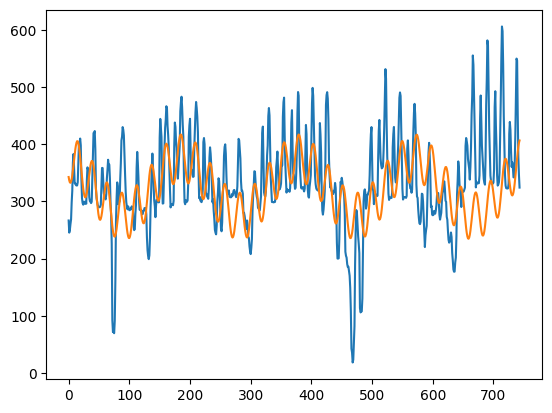

In [12]:
_ = prices.RCE.plot()
_ = plt.plot(prices.index, _price_func(prices.index, *price_params[0]), c='C1')

In [13]:
price_func = lambda x: _price_func(x, *price_params[0])

### Energia

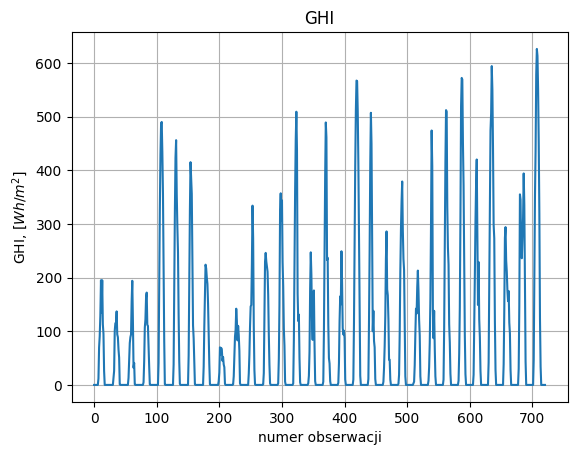

In [14]:
_ = ghi.ghi.plot(title="GHI", grid=True, xlabel="numer obserwacji", ylabel="GHI, [$Wh/m^2$]")

In [15]:
ghi["energy"] = ghi.ghi * np.cos(51.107883) * 1 * 1.65

In [16]:
def _energy_func(x, a, b, c):
    temp = a * np.sin(2 * np.pi * b * x + c)
    return [t if t > 0 else 0 for t in temp]

In [17]:
energy_params = scipy.optimize.curve_fit(_energy_func, ghi.index, ghi.energy,
                                  p0=[ghi.energy.std(),
                                      1/24,
                                      1])

In [18]:
energy_params[0]

array([ 3.10588646e+02,  4.16812220e-02, -1.43877229e+00])

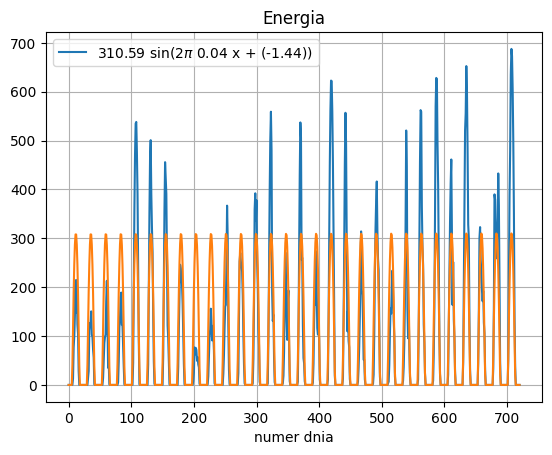

In [19]:
_ = ghi.energy.plot(title="Energia", xlabel="numer dnia", grid=True)
_ = plt.plot(ghi.index, _energy_func(ghi.index, *energy_params[0]), c='C1')
_ = plt.legend(['{} sin(2$\pi$ {} x + ({}))'.
               format(*[np.round(param, 2) for param in energy_params[0]])])

In [20]:
energy_func = lambda x: _energy_func(x, *energy_params[0])

### Zapotrzebowanie

In [55]:
def demand(t, annual_demand=50): # zapotrzebowanie w MWh
    return annual_demand / 365

# Ograniczenia

In [182]:
annual_demand = 0 #[MWh]

In [310]:
Rc = 200 # the energy capacity in Wh
nc = 1  # the charging efficiency of the device
nd = 1  # the discharging efficiency of the device
gc = Rc / 5 # the max charging rate of the device [MWh per hour]
gd = Rc / 5 # the max discharging rate of the device [MWh per hour]
ch = 1  # the holding cost of the device [$ per MWh per time step]

In [311]:
Rc

200

# Zmienne i stan

In [312]:
dates = prices[prices.dt >= '2024-03-11'].dt.reset_index(drop=True)
t = np.arange(len(dates))

S = pd.DataFrame({"P": price_func(t),
                  "D": demand(t, annual_demand),
                  "E": energy_func(t),
                  "R": np.zeros(len(dates))})

phi = np.array([0, 0, -1, nc, nc, -1])

In [313]:
S

,P,D,E,R
0,342.736607,0.0,0.0,0.0
1,336.837196,0.0,0.0,0.0
2,333.391139,0.0,0.0,0.0
3,332.599590,0.0,0.0,0.0
4,334.483734,0.0,0.0,0.0
...,...,...,...,...
259,326.790030,0.0,0.0,0.0
260,320.960067,0.0,0.0,0.0
261,312.892063,0.0,0.0,0.0
262,303.052479,0.0,0.0,0.0


# Rozwiązanie

In [314]:
import pyomo.environ as pyo

### Zmienne

In [315]:
model = pyo.ConcreteModel()
model.Iset = pyo.RangeSet(1, 6)
model.Jset = pyo.RangeSet(0, len(S) - 1)
model.x = pyo.Var(model.Jset, model.Iset, domain=pyo.NonNegativeReals)

### Ograniczenia

In [316]:
def rule1(m, j):
    return m.x[j, 4] + m.x[j, 5] <= Rc - (-1 * sum(m.x[k, 3] for k in m.Jset if k < j) +
                                          nc * (sum(m.x[k, 4] for k in m.Jset if k < j) +
                                                sum(m.x[k, 5] for k in m.Jset if k < j)) -                                sum(m.x[k, 6] for k in m.Jset if k < j))
model.rule1 = pyo.Constraint(model.Jset, rule=rule1)

In [317]:
def rule2(m, j):
    return m.x[j, 1] + nd * m.x[j, 3] + m.x[j, 2] == S.D[j]
model.rule2 = pyo.Constraint(model.Jset, rule=rule2)

In [318]:
def rule3(m, j):
    return m.x[j, 3] + m.x[j, 6] <= -1 * sum(m.x[k, 3] for k in m.Jset if k < j) +\
        nc * (sum(m.x[k, 4] for k in m.Jset if k < j) + sum(m.x[k, 5] for k in m.Jset if k < j)) -\
        sum(m.x[k, 6] for k in m.Jset if k < j)
model.rule3 = pyo.Constraint(model.Jset, rule=rule3)

In [319]:
def rule4(m, j):
    return m.x[j, 4] + m.x[j, 5] <= gc
model.rule4 = pyo.Constraint(model.Jset, rule=rule4)

In [320]:
def rule5(m, j):
    return m.x[j, 3] + m.x[j, 6] <= gd
model.rule5 = pyo.Constraint(model.Jset, rule=rule5)

In [321]:
def rule6(m, j):
    return m.x[j, 4] + m.x[j, 1] <= S.E[j]
model.rule6 = pyo.Constraint(model.Jset, rule=rule6)

### Funkcja

In [322]:
def objective(m):
    return np.sum(S.P * S.D) - sum(S.P[k] * (m.x[k, 5] - nd * m.x[k, 6] + m.x[k, 2]) for k in m.Jset)
model.objective = pyo.Objective(rule=objective, sense=pyo.maximize)

### Rozwiązanie

In [323]:
opt = pyo.SolverFactory('glpk', executable='C:\glpk-4.65\w64\glpsol.exe')

In [324]:
_ = opt.solve(model)

In [325]:
a = np.array([[model.x[j, i].value for i in model.Iset] for j in model.Jset])

In [326]:
columns = ['WD', 'GD', 'RD', 'WR', 'GR', 'RG']
xs = pd.DataFrame(a, columns=columns)

In [327]:
S.R = xs.dot(phi).cumsum()

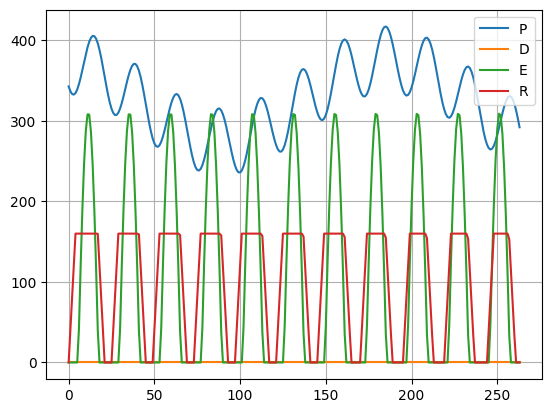

In [329]:
_ = S.plot(grid=True)